In [1]:
# Tensorflow 2.0 Visual Search with using tf.data
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow.keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# The below commented lines are for ResNet and VGG16
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from tensorflow.keras.applications import VGG16
# from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
# Set up the GPU memory size to avoid the out-of-memory error
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# ResNet and VGG16, img_width, img_height = 224, 224
img_width, img_height = 299, 299
NUM_EPOCHS = 5
batchsize = 10
num_train_images = 1350
num_val_images = 156

# For ResNet, InceptionV3 will be replaced by ResNet50, for VGG, InceptionV3 will be replaced by VGG16
base_model = InceptionV3(weights='imagenet', 
                         include_top=False, 
                         input_shape=(img_height, img_width, 3))

In [4]:
# Give the output directory
import pathlib
train_dir = '/home/mike/Documents/keras_inception_v3/furniture_pictures/train'
val_dir = '/home/mike/Documents/keras_inception_v3/furniture_pictures/val'
train_dir = pathlib.Path(train_dir)
val_dir = pathlib.Path(val_dir)
output_dir = 'furniture_images/output'

In [5]:
# Adopt the tf.data to build TensorFlow input pipelines
train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'))
val_ds = tf.data.Dataset.list_files(str(val_dir/'*/*'))
class_list = ["bed", "chair", "sofa", "swivelchair", "table"]

In [6]:
# Print the iamges' directories 
for f in train_ds.take(5):
  print(f.numpy())

b'/home/mic/Documents/Krishnendu_CV2TF/Chapter06/furniture_pictures/train/bed/00000683.jpg'
b'/home/mic/Documents/Krishnendu_CV2TF/Chapter06/furniture_pictures/train/sofa/00000717.jpg'
b'/home/mic/Documents/Krishnendu_CV2TF/Chapter06/furniture_pictures/train/chair/00000389.jpg'
b'/home/mic/Documents/Krishnendu_CV2TF/Chapter06/furniture_pictures/train/sofa/00000465.jpg'
b'/home/mic/Documents/Krishnendu_CV2TF/Chapter06/furniture_pictures/train/bed/00000098.jpg'


In [7]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == class_list

In [8]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [img_width, img_height])

In [9]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [10]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_labeled_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (299, 299, 3)
Label:  [False False  True False False]


In [11]:
val_labeled_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in val_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (299, 299, 3)
Label:  [False False  True False False]


In [12]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # Only load the small dataset once, and keep it in memory，use `.cache(filename)` 
  # to cache preprocessing work for datasets that don't fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(batchsize)

  # `prefetch` lets fetch batches in the background while the model is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [13]:
train_ds = prepare_for_training(train_labeled_ds)
train_image_batch, label_batch = next(iter(train_ds))
val_ds = prepare_for_training(val_labeled_ds)
val_image_batch, label_batch = next(iter(val_ds))

In [14]:
def build_final_model(base_model, dropout, fc_layers, num_classes):
    
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    
    # Finetune from the layer onwards
    layer_adjust = 100
    # Freeze all the layers before the finetune_at` layer
    
    for layer in base_model.layers[:layer_adjust]:
      layer.trainable =  False

    for fc in fc_layers:
        # New FC layer, random initialization
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    final_model = Model(inputs=base_model.input, outputs=predictions)

    return final_model

class_list = ["bed", "chair", "sofa", "swivelchair", "table"]
FC_LAYERS = [1024, 1024]
dropout = 0.3

final_model = build_final_model(base_model, 
                                dropout=dropout, 
                                fc_layers=FC_LAYERS, 
                                num_classes=len(class_list))

In [15]:
# Give the checkpoint 
outputpath=output_dir+"/model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint_callback = ModelCheckpoint(outputpath, 
                                      monitor='val_accuracy', 
                                      verbose=1,
                                      save_best_only=False, 
                                      save_weights_only=False,
                                      save_frequency=1)

In [16]:
# Compile the model 
adam = Adam(lr=0.00001)
final_model.compile(adam, 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

In [17]:
# Train the model 
history = final_model.fit(train_ds,
                          epochs=NUM_EPOCHS,
                          steps_per_epoch=num_train_images // batchsize,
                          callbacks=[checkpoint_callback],
                          validation_data=val_ds, 
                          validation_steps=num_val_images // batchsize)

Epoch 1/5
135/135 [==============================] - ETA: 0s - loss: 1.2373 - accuracy: 0.5704
Epoch 00001: saving model to furniture_images/output/model-01-0.86.hdf5
135/135 [==============================] - 11s 84ms/step - loss: 1.2373 - accuracy: 0.5704 - val_loss: 0.7128 - val_accuracy: 0.8600
Epoch 2/5
135/135 [==============================] - ETA: 0s - loss: 0.6320 - accuracy: 0.8430
Epoch 00002: saving model to furniture_images/output/model-02-0.93.hdf5
135/135 [==============================] - 10s 72ms/step - loss: 0.6320 - accuracy: 0.8430 - val_loss: 0.3045 - val_accuracy: 0.9267
Epoch 3/5
135/135 [==============================] - ETA: 0s - loss: 0.3623 - accuracy: 0.8985
Epoch 00003: saving model to furniture_images/output/model-03-0.95.hdf5
135/135 [==============================] - 10s 72ms/step - loss: 0.3623 - accuracy: 0.8985 - val_loss: 0.1941 - val_accuracy: 0.9467
Epoch 4/5
135/135 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9348
Epoch

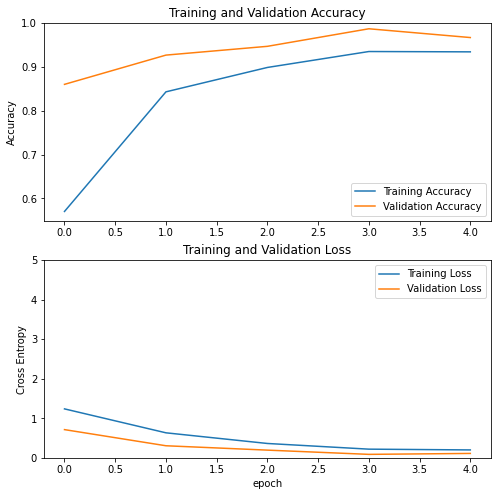

In [18]:
# Plot the diagrams for both accuracy and loss
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
# Print the pretrained feature ID and y_classes 
from keras.preprocessing import image
import numpy as np

# The below path shows the full path for uploaded image, adjust it for your specific path
img_path = ''/home/mike/Documents/keras_inception_v3/furniture_pictures/val/sofa/00000360.jpg'
img = image.load_img(img_path, target_size=(img_width, img_height))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data1 = preprocess_input(img_data)

pretrained_feature = final_model.predict(img_data,verbose=0)
pretrained_feature_np = np.array(pretrained_feature)
pretrained_feature1D = pretrained_feature_np.flatten()

pretrained_feature_base = base_model.predict(img_data1)
pretrained_feature_np_base = np.array(pretrained_feature_base)
pretrained_feature1D_base = pretrained_feature_np_base.flatten()

print (pretrained_feature1D)

y_prob = final_model.predict(img_data)
y_classes = y_prob.argmax(axis=-1)

print(y_classes)

[0.00735246 0.00125233 0.9877257  0.00244108 0.0012284 ]
[2]


In [20]:
import os
from scipy.spatial import distance as dist
from sklearn.metrics.pairwise import cosine_similarity

# Below shows the full path for test images, adjust it for your specific path
if y_classes == [0]:
    path = '/home/mike/Documents/keras_inception_v3/furniture_pictures/test/bed'
elif y_classes == [1]:
    path = '/home/mike/Documents/keras_inception_v3/furniture_pictures/test/chair'
else:
    path = '/home/mike/Documents/keras_inception_v3/furniture_pictures/test/sofa'
    
mindist=10000
maxcosine =0
i=0

for filename in os.listdir(path):
    image_train = os.path.join(path, filename)
    i +=1
    imgtrain = image.load_img(image_train, target_size=(img_width, img_height))
    img_data_train = image.img_to_array(imgtrain)
    img_data_train = np.expand_dims(img_data_train, axis=0)
    img_data_train = preprocess_input(img_data_train)

    pretrained_feature_train = base_model.predict(img_data_train)
    pretrained_feature_np_train = np.array(pretrained_feature_train)
    pretrained_feature_train1D = pretrained_feature_np_train.flatten()
    eucldist = dist.euclidean(pretrained_feature1D_base,pretrained_feature_train1D)
    
    if mindist > eucldist:
        mindist=eucldist
        minfilename = filename
    # print (vgg16_feature_np)
    
    dot_product = np.dot(pretrained_feature1D_base,pretrained_feature_train1D)#normalize the results, to achieve similarity measures independant #of the scale of the vectors
    norm_Y = np.linalg.norm(pretrained_feature1D_base)
    norm_X = np.linalg.norm(pretrained_feature_train1D)
    cosine_similarity = dot_product / (norm_X * norm_Y)
    
    if maxcosine < cosine_similarity:
        maxcosine=cosine_similarity
        cosfilename = filename
    
    print ("%s filename %f euclediandist %f cosine_similarity" %(filename,eucldist,cosine_similarity))
    print ("%s minfilename %f mineuclediandist %s cosfilename %f maxcosinesimilarity" %(minfilename,mindist, cosfilename, maxcosine))

00000069.jpg filename 262.926544 euclediandist 0.396598 cosine_similarity
00000069.jpg minfilename 262.926544 mineuclediandist 00000069.jpg cosfilename 0.396598 maxcosinesimilarity
00000202.jpg filename 237.338379 euclediandist 0.528461 cosine_similarity
00000202.jpg minfilename 237.338379 mineuclediandist 00000202.jpg cosfilename 0.528461 maxcosinesimilarity
00000419.jpg filename 232.662308 euclediandist 0.532219 cosine_similarity
00000419.jpg minfilename 232.662308 mineuclediandist 00000419.jpg cosfilename 0.532219 maxcosinesimilarity
00000013.jpg filename 280.911957 euclediandist 0.308751 cosine_similarity
00000419.jpg minfilename 232.662308 mineuclediandist 00000419.jpg cosfilename 0.532219 maxcosinesimilarity
00000353.jpg filename 294.658264 euclediandist 0.391158 cosine_similarity
00000419.jpg minfilename 232.662308 mineuclediandist 00000419.jpg cosfilename 0.532219 maxcosinesimilarity
00000709.jpg filename 269.916107 euclediandist 0.345298 cosine_similarity
00000419.jpg minfilen

00000856.jpg filename 285.410828 euclediandist 0.304525 cosine_similarity
00000419.jpg minfilename 232.662308 mineuclediandist 00000419.jpg cosfilename 0.532219 maxcosinesimilarity
00000769.jpg filename 252.300888 euclediandist 0.502039 cosine_similarity
00000419.jpg minfilename 232.662308 mineuclediandist 00000419.jpg cosfilename 0.532219 maxcosinesimilarity
00000647.jpg filename 242.253815 euclediandist 0.457046 cosine_similarity
00000419.jpg minfilename 232.662308 mineuclediandist 00000419.jpg cosfilename 0.532219 maxcosinesimilarity
00000975.jpg filename 237.735016 euclediandist 0.515454 cosine_similarity
00000419.jpg minfilename 232.662308 mineuclediandist 00000419.jpg cosfilename 0.532219 maxcosinesimilarity
00000536.jpg filename 236.937271 euclediandist 0.475310 cosine_similarity
00000419.jpg minfilename 232.662308 mineuclediandist 00000419.jpg cosfilename 0.532219 maxcosinesimilarity
00000074.jpg filename 282.073517 euclediandist 0.314690 cosine_similarity
00000419.jpg minfilen

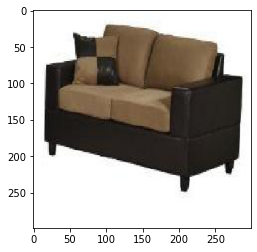

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
image_result = os.path.join(path, minfilename)
imgresult = image.load_img(image_train, target_size=(224, 224))
plt.imshow(img)

Text(0.5, 1.0, 'Cosine_Similarity 0.5813875')

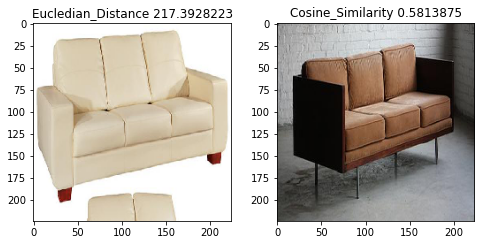

In [22]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(2,2,1)
image_result1 = os.path.join(path, minfilename)
imgresult1 = image.load_img(image_result1, target_size=(224, 224))
plt.imshow(imgresult1)
eucledian5d ="%.7f" % mindist
plt.title("Eucledian_Distance " + str(eucledian5d))

fig.add_subplot(2,2,2)
image_result2 = os.path.join(path, cosfilename)
imgresult2 = image.load_img(image_result2, target_size=(224, 224))
plt.imshow(imgresult2)
cosine5d ="%.7f" % maxcosine
plt.title("Cosine_Similarity " + str(cosine5d))

In [23]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(batchsize*steps/duration))

In [24]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batchsize)

Found 3200 images belonging to 5 classes.


In [25]:
timeit(train_generator)

....................................................................................................
1000 batches: 181.5445840358734 s
55.08289 Images/s


In [26]:
timeit(train_ds)

....................................................................................................
1000 batches: 1.8679277896881104 s
5353.52601 Images/s
